# Visualizing the distribution time of promotional emails

Let's start with the basic preambles: inline `matplotlib` and `numpy` for general purposes.

We begin be deciding which group to load, in this case we are loading the LinkedIn email data.

Then we load the data into a list and split the spaces so we get the information we need in a tuple-like structure

In [1]:
%matplotlib inline
import numpy as np

title = "YouTube"
fn = "youtube"
with open("normalized/" + fn + "_normalized.txt", "r") as f:
    data = f.read().splitlines()

data = [i.split() for i in data]
print("Number of rows:", len(data))
print(data[0])

Number of rows: 1391
['Mon', 'Apr', '29', '2013', '07:08:34', 'GMT+0000']


So the dataset is a bit of a mess because it is naively mined: there are lots of redundant values for a single email. 

Let's assume that mail is sent only once per day; with this information we can use a `dict` to store the time (in hours from midnight) on which an email is received.

We can then take the average of the time and assume that is the time the email was sent.

There are some extra variables needed for the months (the `to_mm dict`); this is mainly for creating a `pandas DataFrame` to be used later.

In [2]:
import pandas as pd

to_mm = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}

def time_to_hours(s):
    h, m, s = s.split(":")
    h = int(h)
    m = int(m) / 60
    s = int(s) / 3600
    return h + m + s

day_dict = {}
day_dict_count = {}

for d in data:
    day_id = d[1] + d[2] + d[3]

    if day_id in day_dict:
        day_dict[day_id] += time_to_hours(d[4])
        day_dict_count[day_id] += 1

    else:
        day_dict[day_id] = time_to_hours(d[4])
        day_dict_count[day_id] = 1

data_r = np.array([day_dict[d] / day_dict_count[d] for d in day_dict.keys()])
data_r_ts = np.array([pd.Timestamp(int(d[-4:]), to_mm[d[:3]], int(d[3:5])) for d in day_dict.keys()])
print("Reduced rows:", len(data_r))
print(data_r[:5])

Reduced rows: 1186
[ 22.03055556  11.88013889   7.72666667  19.91333333   3.10361111]


We now have rows for each day an email was sent and the time (in hours after midnight) when the mail was received.

We now put this into a `pandas DataFrame` object to ease plotting later.

In [3]:
df = pd.DataFrame(data_r, columns=["Time"], index=data_r_ts)
df.index.name = "Date"
df = df.sort_index()
df.head()

,Time
Date,
2013-04-29,7.142778
2013-05-01,0.045833
2013-05-02,15.822500
2013-05-03,18.805139
2013-05-04,11.436667


## Plotting the data

It's good to get some context for the data distribution through traditional plots

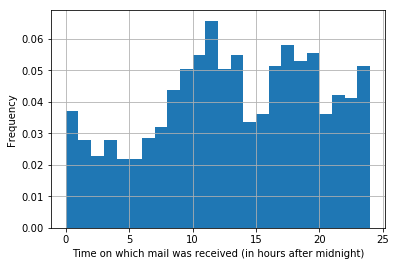

In [4]:
ax = df.Time.hist(normed=True, bins=24)
ax.set_xlabel("Time on which mail was received (in hours after midnight)")
ax.set_ylabel("Frequency")

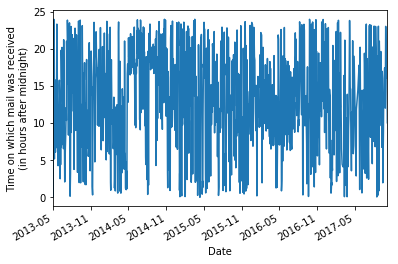

In [5]:
ax = df.Time.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Time on which mail was received\n(in hours after midnight)")

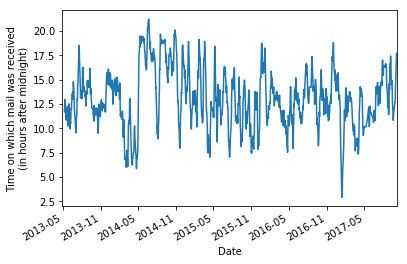

In [6]:
r = df.Time.rolling(window=10)
ax = r.mean().plot()
ax.set_xlabel("Date")
ax.set_ylabel("Time on which mail was received\n(in hours after midnight)")

## A cyclic visualization method

We can try to visualise the distribution in the form of a clock since time is cyclic.

This shoudl give a better idea on how the emails cluster, expecially around midnight which is hard to see in histograms.

The idea below is to first normalize the time values $v$ (i.e. hours from midnight of the day on which the email is received) to circular cartesian coordinates. This is done by setting $v = 0 \rightarrow 0$ and $v = 24 \rightarrow 2\pi$. Since $0 = 2\pi$, then we can better cluster the points which are at midnight. We can convert the values to the $0$ to $2\pi$ range by using the equation $$ \hat{v} = 2\pi \frac{v}{24} $$

So we want a relatively large circle radius to draw the clock numbers within. But all the points are going to cluster very closely only around the circumference of the circle. To better visualize the point distribution, we will add some random noise to the circle radius, keeping the angle of the points (i.e. the representative time of the email being sent) while spreading the points out showing how many points are around that time. To calculate the cartesian coordinates of the circle we use the equations $$ x = r \cos(\hat{v}) $$ $$ y = r \sin(\hat{v}) $$

The graph is colored to show the chronological position of the emails. Darker points are earlier while brighter points are later.

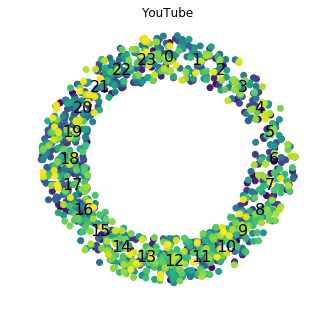

In [7]:
import matplotlib.pyplot as plt

twopi = 2 * np.pi
v = df.Time.values.astype(np.float)
v_hat = v / 24 * twopi

x_noise = np.random.uniform(size=df.Time.values.shape[0]) + 1.75
# x_noise = 2
y_noise = np.random.uniform(size=df.Time.values.shape[0]) + 1.75
# y_noise = 2

x = x_noise * np.cos(v_hat)
y = y_noise * np.sin(v_hat)

plt.figure(figsize=(5,5))

a = 2.25
for i in range(24):
    i_hat = i / 24 * twopi
    lx = a * np.cos(i_hat) - .1
    ly = a * np.sin(i_hat) - .1
    plt.annotate(str(i), xy=(ly, lx), fontsize=16)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axis('off')
plt.title(title)
plt.scatter(y, x, c=df.index)

### EXPERIMENTAL COLORBARS! ###
# def datestring_from_time(t):
#     d = pd.Timestamp(int(t))
#     out = str(d).split()[0]
#     return out
#
# last = df.index[-1].value
# first = df.index[0].value
# ticks = [first + (i * (last - first) / 4) for i in range(5)]
# ticklabels = list(map(datestring_from_time, ticks))
# cbar = plt.colorbar(ticks=ticks)
# cbar.ax.set_yticklabels(ticklabels)
###
plt.savefig(fn + ".svg")